<a href="https://colab.research.google.com/github/stevejobws/Colaboratory/blob/master/gcn_pridiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install torchtext
!pip install torchvision
!pip install torch_sparse -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install torch_scatter -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install torch_geometric # 下载安装pytorch_geometric
!pip install networkx # 画图
import torch
import torch.nn.functional as F
import torch_geometric 
from torch_geometric.nn import GCNConv, ChebConv

In [ ]:
! python -c "import torch_geometric; print(torch_geometric.__version__)" # 检查是否安装成功

In [ ]:
! uname -a  # 查看系统  
! python --version  # 查看python版本 
! python -c 'import torch; print(torch.version.cuda)' # 查看cuda的版本，检查是否和cuda的一致
! nvcc --version # 查看nvcc版本 

Linux e4e606ebf6e4 4.19.112+ #1 SMP Thu Jul 23 08:00:38 PDT 2020 x86_64 x86_64 x86_64 GNU/Linux
Python 3.6.9
10.1
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
print(torch.version.cuda) # torch的cuda版本

10.1


In [ ]:
import torch
print("hello torch{}".format(torch.__version__))


hello torch1.6.0+cu101


# 1. 预处理数据集的格式，转化为GCN所需要的格式

In [1]:
import tensorflow as tf # Orange 1.14.0
print(tf.__version__)
import keras # 2.2.5
print(keras.__version__)

2.3.0
2.4.3


In [2]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.5

     |████████████████████████████████| 109.2MB 87kB/s 
     |████████████████████████████████| 3.2MB 33.4MB/s 
     |████████████████████████████████| 491kB 45.5MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


     |████████████████████████████████| 337kB 2.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


### 1.1 import file is  attribute of node

In [1]:
import pandas as pd
import numpy as np
node_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/AllNodeAttribute18416.csv',header = None) 
num = node_features.shape[0] # Number of nodes
node_features  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,0,0.016331,0.146668,0.725543,0.174163,0.000000,0.089384,0.000000,0.000000,0.711078,0.535862,0.000000,0.000000,0.070424,0.459120,0.000000,0.451255,0.134811,0.338473,0.122156,0.509349,0.282891,0.000000,0.367115,0.452088,0.251513,0.886946,0.101663,0.000000,0.065272,0.000000,0.440651,0.401696,0.095689,0.765287,0.526771,1.057028,0.098744,0.023218,0.342406,0.566687,0.000000,0.696072,0.586652,0.262387,0.000000,0.077090,0.423339,0.185215,0.0000,0.281270,0.000000,0.184586,0.000000,0.407317,0.605318,0.327069,0.909140,0.000000,0.000000,0.788762,0.312990,0.078151,0.000000,0.783508
1,1,0.435840,1.204385,0.000000,0.441521,0.000000,0.839651,0.000000,0.000000,1.316772,1.094028,0.000000,0.000000,0.400978,0.308016,0.000000,0.221955,0.485380,1.558614,0.000000,1.246036,0.000000,0.000000,0.682492,0.366790,0.751529,0.526286,1.971504,0.000000,0.000000,0.000000,0.339621,1.621154,0.883370,0.523618,1.788122,1.439940,0.159284,0.284751,0.669727,1.761021,2.606565,0.139260,0.794215,0.608262,1.132268,0.994848,0.020278,0.017182,0.0000,1.019694,0.077861,0.057064,0.000000,0.000000,1.567412,0.270772,1.786874,0.516166,0.085904,0.931137,0.525576,0.000000,1.032238,1.385969
2,2,0.000000,0.259270,0.000000,0.324180,0.309331,0.014996,0.460173,0.708755,0.751080,0.338239,0.000000,0.000000,0.104922,0.051036,0.000000,0.848546,0.000000,0.795172,0.203561,0.433606,0.000000,0.197207,0.354380,0.020565,0.197066,0.209536,1.022902,0.000000,0.095886,0.000000,0.840677,0.292150,0.025301,0.117673,0.248926,0.918377,0.000000,0.000000,0.186953,0.638557,1.504499,0.000000,0.845216,0.869688,0.231062,0.741330,0.118901,0.233369,0.0000,0.793322,0.430846,0.668513,0.000000,0.165300,0.591209,0.688688,1.253160,0.000000,0.045387,0.000000,0.779330,0.629813,0.000000,1.082397
3,3,0.165230,0.978996,0.000000,0.744489,0.258909,0.060296,0.168233,0.199796,1.103272,0.251078,0.098119,0.000000,0.000000,0.238727,0.000000,0.169436,0.174725,0.665714,0.704781,1.123834,0.503610,0.065120,0.332690,0.198439,0.766891,1.167586,0.296143,0.298238,1.088058,0.000000,0.000000,0.081464,0.504218,0.610977,0.868126,0.849582,0.107903,0.000000,0.000000,0.588164,0.545574,0.497186,1.005129,0.722074,0.089798,0.783461,0.030348,0.506543,0.0000,0.249757,0.000000,0.302376,0.000000,0.250245,0.990561,0.558670,1.217978,0.378977,0.257189,0.548955,1.136081,0.168006,0.032234,0.747449
4,4,0.268873,0.000000,0.454440,0.153748,0.429066,0.313568,0.000000,0.163547,1.020495,0.254495,0.000000,0.000000,0.097542,0.000000,0.000000,0.487418,0.404117,0.000000,0.618405,0.683403,0.000000,0.113998,0.010242,0.214518,0.271182,0.454820,0.277028,0.014495,0.539655,0.332845,0.143752,0.132466,0.399873,0.112376,0.291646,0.000000,0.716976,0.134282,0.205520,0.492683,0.741167,0.038630,0.232192,0.230327,0.278061,0.603764,0.000000,0.605231,0.0000,0.676816,0.057315,0.464129,0.181568,0.000000,0.149361,0.000000,0.150121,0.000000,0.166518,0.509469,0.370294,0.536197,0.033468,0.491073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,862,0.000000,0.000000,0.056832,0.084803,0.001036,0.000000,0.000000,0.066325,0.099736,0.012418,0.000000,0.087421,0.000000,0.099734,0.036357,0.000000,0.047761,0.033273,0.000000,0.095286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005404,0.016310,0.000000,0.000000,0.000000,0.056599,0.001209,0.056369,0.000000,0.000000,0.043184,0.011914,0.000000,0.000000,0.000000,0.015901,0.000000,0.000000,0.060415,0.000000,0.045033,0.000000,0.0000,0.000000,0.003504,0.000000,0.023373,0.000000,0.000000,0.000000,0.000000,0.037773,0.000000,0.005106,0.147170,0.000000,0.000000,0.000000
863,863,0.057513,0.000000,0.132687,0.071455,0.000000,0.000000,0.000000,0.00341

In [2]:
# 将词向量提取为特征,第二列到倒数第一列
features =node_features.iloc[:,1:]
 # 检查特征：共64个特征，837个样本点
print(features.shape)

(867, 64)


In [3]:
# 提取节点标签
node_label = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/AllNode_label18416.csv',header = None)
labels = node_label[1] # 提取节点标签列
labels[:5]

0    0
1    0
2    0
3    0
4    0
Name: 1, dtype: int64

In [4]:
filename1 = '/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/drug-diseaseNum18416.csv'
def load_file_as_Adj_matrix(filename):
  '''
  Read .rating file and Return dok matrix.
  The first line of .rating file is: num_users\t num_items
  '''
  # Get number of users and items
  num_users, num_items = 0, 0
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split(",")
      u, i = int(arr[0]), int(arr[1])
      num_users = max(num_users, u)
      num_items = max(num_items, i)
      line = f.readline()
  # Construct matrix
  print(num_users)
  print(num_items)
  relation_matrix = np.zeros((num_items+1,num_items+1))
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split(",")
      # user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
      # if (rating > 0):
      user, item = int(arr[0]), int(arr[1])
      relation_matrix[user, item] = 1
      line = f.readline()    
  return relation_matrix
Adj = load_file_as_Adj_matrix(filename1)
import scipy.sparse as sp
Adj = sp.csr_matrix(Adj, dtype=np.float32)
Adj.todense()

268
866


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
import scipy.sparse as sp
def load_data(adj,node_features,node_labels):
  features = sp.csr_matrix(node_features, dtype=np.float32)  # 储存为csr型稀疏矩阵
  # build symmetric adjacency matrix   论文里A^=(D~)^0.5 A~ (D~)^0.5这个公式
  # adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
  # 对于无向图，邻接矩阵是对称的。上一步得到的adj是按有向图构建的，转换成无向图的邻接矩阵需要扩充成对称矩阵
  features = normalize(features)
  adj = normalize(adj + sp.eye(adj.shape[0]))   # eye创建单位矩阵，第一个参数为行数，第二个为列数
  # 对应公式A~=A+IN
  # 分别构建训练集、验证集、测试集，并创建特征矩阵、标签向量和邻接矩阵的tensor，用来做模型的输入
  idx_train = range(500)
  idx_val = range(500, 660)
  idx_test = range(660, int(adj.shape[0]))  
  features = torch.FloatTensor(np.array(features.todense()))  # tensor为pytorch常用的数据结构
  labels = torch.LongTensor(np.array(node_labels))
  adj = sparse_mx_to_torch_sparse_tensor(adj)   # 邻接矩阵转为tensor处理
  idx_train = torch.LongTensor(idx_train)
  idx_val = torch.LongTensor(idx_val)
  idx_test = torch.LongTensor(idx_test)
  return adj, features, labels, idx_train, idx_val, idx_test  
def normalize(mx):
  """Row-normalize sparse matrix"""
  rowsum = np.array(mx.sum(1))  # 对每一行求和
  r_inv = np.power(rowsum, -1).flatten()  # 求倒数
  r_inv[np.isinf(r_inv)] = 0.  # 如果某一行全为0，则r_inv算出来会等于无穷大，将这些行的r_inv置为0
  r_mat_inv = sp.diags(r_inv)  # 构建对角元素为r_inv的对角矩阵
  mx = r_mat_inv.dot(mx)
  # 用对角矩阵与原始矩阵的点积起到标准化的作用，原始矩阵中每一行元素都会与对应的r_inv相乘，最终相当于除以了sum
  return mx

def accuracy(output, labels):
  preds = output.max(1)[1].type_as(labels) # 使用type_as(tesnor)将张量转换为给定类型的张量。
  correct = preds.eq(labels).double()  # 记录等于preds的label eq:equal
  correct = correct.sum()
  return correct / len(labels)

def sparse_mx_to_torch_sparse_tensor(sparse_mx):    # 把一个sparse matrix转为torch稀疏张量
  """
  numpy中的ndarray转化成pytorch中的tensor : torch.from_numpy()
  pytorch中的tensor转化成numpy中的ndarray : numpy()
  """
  sparse_mx = sparse_mx.tocoo().astype(np.float32)
  indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
  # 不懂的可以去看看COO性稀疏矩阵的结构
  values = torch.from_numpy(sparse_mx.data)
  shape = torch.Size(sparse_mx.shape)
  return torch.sparse.FloatTensor(indices, values, shape)

In [6]:
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

class GraphConvolution(Module):

    # 初始化层：输入feature，输出feature，权重，偏移
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))  # FloatTensor建立tensor
        # 常见用法self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))：
        # 首先可以把这个函数理解为类型转换函数，将一个不可训练的类型Tensor转换成可以训练的类型parameter并将这个parameter
        # 绑定到这个module里面，所以经过类型转换这个self.v变成了模型的一部分，成为了模型中根据训练可以改动的参数了。
        # 使用这个函数的目的也是想让某些变量在学习的过程中不断的修改其值以达到最优化。
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
            # Parameters与register_parameter都会向parameters写入参数，但是后者可以支持字符串命名
        self.reset_parameters()

    # 初始化权重
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        # size()函数主要是用来统计矩阵元素个数，或矩阵某一维上的元素个数的函数  size（1）为行
        self.weight.data.uniform_(-stdv, stdv)  # uniform() 方法将随机生成下一个实数，它在 [x, y] 范围内
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    '''
    前馈运算 即计算A~ X W(0)
    input X与权重W相乘，然后adj矩阵与他们的积稀疏乘
    直接输入与权重之间进行torch.mm操作，得到support，即XW
    support与adj进行torch.spmm操作，得到output，即AXW选择是否加bias
    '''
    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        # torch.mm(a, b)是矩阵a和b矩阵相乘，torch.mul(a, b)是矩阵a和b对应位相乘，a和b的维度必须相等
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias 
        else:
            return output
#通过设置断点，可以看出output的形式是0.01，0.01，0.01，0.01，0.01，#0.01，0.94]，里面的值代表该x对应标签不同的概率，故此值可转换为#[0,0,0,0,0,0,1]，对应我们之前把标签onthot后的第七种标签

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'



In [7]:
import torch.nn as nn
import torch.nn.functional as F
class GCN(nn.Module):
  def __init__(self, nfeat, nhid, nclass, dropout):
    # 底层节点的参数，feature的个数；隐层节点个数；最终的分类数
    super(GCN, self).__init__()  #  super()._init_()在利用父类里的对象构造函数
    self.gc1 = GraphConvolution(nfeat, nhid)   # gc1输入尺寸nfeat，输出尺寸nhid
    self.gc2 = GraphConvolution(nhid, nclass)  # gc2输入尺寸nhid，输出尺寸ncalss
    self.dropout = dropout
    self.weight = Parameter(torch.FloatTensor(nfeat, nhid))  # FloatTensor建立tensor
    # 输入分别是特征和邻接矩阵。最后输出为输出层做log_softmax变换的结果
  def forward(self, x, adj):
    x = F.relu(self.gc1(x, adj))    # adj即公式Z=softmax(A~Relu(A~XW(0))W(1))中的A~
    x1 = F.dropout(x, self.dropout, training = self.training)  # x要dropout
    x2 = self.gc2(x1, adj)
    return F.log_softmax(x2, dim = 1), x   #, x  # 参数dim=1表示对每一行求softmax，那么每一行的值加起来都等于1。

Epoch: 0001 loss_train: 0.6928 acc_train: 0.5760 loss_val: 0.8921 acc_val: 0.0000 time: 0.0238s
Epoch: 0002 loss_train: 0.6946 acc_train: 0.5380 loss_val: 0.8479 acc_val: 0.0000 time: 0.0097s
Epoch: 0003 loss_train: 0.6906 acc_train: 0.5380 loss_val: 0.7633 acc_val: 0.0063 time: 0.0084s
Epoch: 0004 loss_train: 0.6880 acc_train: 0.5540 loss_val: 0.7044 acc_val: 0.3875 time: 0.0079s
Epoch: 0005 loss_train: 0.6893 acc_train: 0.7080 loss_val: 0.7030 acc_val: 0.4250 time: 0.0074s
Epoch: 0006 loss_train: 0.6878 acc_train: 0.7100 loss_val: 0.7367 acc_val: 0.2188 time: 0.0085s
Epoch: 0007 loss_train: 0.6850 acc_train: 0.6640 loss_val: 0.7800 acc_val: 0.0813 time: 0.0085s
Epoch: 0008 loss_train: 0.6843 acc_train: 0.5780 loss_val: 0.8121 acc_val: 0.0500 time: 0.0085s
Epoch: 0009 loss_train: 0.6832 acc_train: 0.5560 loss_val: 0.8169 acc_val: 0.0688 time: 0.0092s
Epoch: 0010 loss_train: 0.6833 acc_train: 0.5660 loss_val: 0.7938 acc_val: 0.1562 time: 0.0087s
Epoch: 0011 loss_train: 0.6809 acc_train

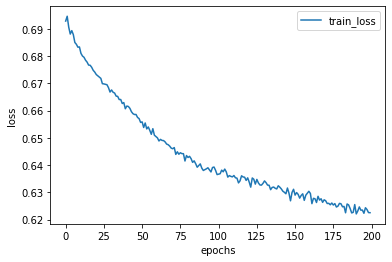

In [8]:
from __future__ import division
from __future__ import print_function
import time
import argparse  # argparse 是python自带的命令行参数解析包，可以用来方便地读取命令行参数
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

# Training settings
learning_rate = 0.01
weight_decay = 5e-4
epoch_num = 200
dropout = 0.02
#in_size = node_features  #设置输入层的维数
hi_size = 64 # 16 #设置隐藏层的维数
#out_size = node_label #设置输入层的维数


# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data(Adj,features,labels)

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=hi_size,
            nclass=labels.max().item() + 1,
            dropout=dropout)
optimizer = optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)

# 数据写入cuda，便于后续加速

# if args.cuda:
#     model.cuda()   # . cuda()会分配到显存里（如果gpu可用）
#     features = features.cuda()
#     adj = adj.cuda()
#     labels = labels.cuda()
#     idx_train = idx_train.cuda()
#     idx_val = idx_val.cuda()
#     idx_test = idx_test.cuda()
#global node_vec
train_loss = []
def train(epoch_num):
  t = time.time()  # 返回当前时间
  model.train()
  optimizer.zero_grad()
  # optimizer.zero_grad()意思是把梯度置零，也就是把loss关于weight的导数变成0.
  # pytorch中每一轮batch需要设置optimizer.zero_gra
  global Emdebding_train, output
  output, Emdebding_train = model(features, adj)
  loss_train = F.nll_loss(output[idx_train], labels[idx_train])
  train_loss.append(loss_train)
  # 由于在算output时已经使用了log_softmax，这里使用的损失函数就是NLLloss，如果前面没有加log运算，
  # 这里就要使用CrossEntropyLoss了
  # 损失函数NLLLoss() 的输入是一个对数概率向量和一个目标标签. 它不会为我们计算对数概率，
  # 适合最后一层是log_softmax()的网络. 损失函数 CrossEntropyLoss() 与 NLLLoss() 类似,
  # 唯一的不同是它为我们去做 softmax.可以理解为：CrossEntropyLoss()=log_softmax() + NLLLoss()
  # https://blog.csdn.net/hao5335156/article/details/80607732
  acc_train = accuracy(output[idx_train], labels[idx_train])  #计算准确率
  loss_train.backward()  # 反向求导  Back Propagation
  optimizer.step()  # 更新所有的参数  Gradient Descent
    
  #if not args.fastmode:
      # Evaluate validation set performance separately,
      # deactivates dropout during validation run.
  model.eval()  # eval() 函数用来执行一个字符串表达式，并返回表达式的值
  global Emdebding_eval
  output, Emdebding_eval = model(features, adj)
  loss_val = F.nll_loss(output[idx_val], labels[idx_val])    # 验证集的损失函数
  acc_val = accuracy(output[idx_val], labels[idx_val])
  print('Epoch: {:04d}'.format(epoch+1),     
        'loss_train: {:.4f}'.format(loss_train.item()),
        'acc_train: {:.4f}'.format(acc_train.item()),
        'loss_val: {:.4f}'.format(loss_val.item()),
        'acc_val: {:.4f}'.format(acc_val.item()),
        'time: {:.4f}s'.format(time.time() - t))

# 定义测试函数，相当于对已有的模型在测试集上运行对应的loss与accuracy
def test():
  model.eval()
  global Emdebding_test
  output, Emdebding_test = model(features, adj)
  loss_test = F.nll_loss(output[idx_test], labels[idx_test])
  acc_test = accuracy(output[idx_test], labels[idx_test])
  print("Test set results:",
        "loss= {:.4f}".format(loss_test.item()),
        "accuracy= {:.4f}".format(acc_test.item()))

# Train model  逐个epoch进行train，最后test
t_total = time.time()
for epoch in range(epoch_num):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
test()
import matplotlib.pyplot as plt
import time
epochs = len(train_loss)
plt.plot(range(0,epochs,1), train_loss, label='train_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
#plt.savefig("/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/image/"+time.strftime("%Y-%m-%d-%H_%M_%S",time.localtime(time.time()))+"Unet-过拟合C0.jpg")
plt.show()

建立NeuMF层模型

In [9]:
import numpy as np
import theano
import theano.tensor as T
import keras
from keras import backend as K
from keras import initializers
#from keras import initializations
from keras.regularizers import l1, l2#, l1l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from time import time
import sys
import argparse
import scipy.sparse as sp

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

使用数据生成正负样本

In [10]:
def load_rating_file_as_matrix(filename):
  '''
  Read .rating file and Return dok matrix.
  The first line of .rating file is: num_users\t num_items
  '''
  # Get number of users and items
  num_users, num_items = 0, 0
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split(",")
      u, i = int(arr[0]), int(arr[1])
      num_users = max(num_users, u)
      num_items = max(num_items, i)
      line = f.readline()
  # Construct matrix
  print(num_users)
  print(num_items)
  mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split(",")
      #user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
      #if (rating > 0):
      user, item = int(arr[0]), int(arr[1])
      mat[user, item] = 1.0
      line = f.readline()    
  return mat

In [11]:
filename = '/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/drug-diseaseNum18416.csv'
train_Martrix = load_rating_file_as_matrix(filename)
train_Martrix

268
866


<269x867 sparse matrix of type '<class 'numpy.float32'>'
	with 18416 stored elements in Dictionary Of Keys format>

将vector of each nodes construct a serise of pairs of nodes

In [ ]:
# 读取负样本
N_filename = '/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/NegativeSample.txt'
negative_data = pd.read_table(N_filename,sep='\t',header=None)
negative_data = negative_data[:17414]
negative_data

,0,1
0,4,279
1,4,557
2,4,543
3,4,421
4,4,666
...,...,...
17409,264,748
17410,264,738
17411,264,636
17412,264,523


In [12]:
# 读取Embedding node2vec
E_filename = '/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/Embedding_Node2vec18416.txt'
Embedding_Node2vec = pd.read_csv(E_filename,sep=' ',header=None)
Embedding_Node2vec = Embedding_Node2vec.sort_values(0,ascending=True)# 建立序号排序
Embedding_Node2vec.reset_index(drop=True, inplace=True) 
Embedding_Node2vec = Embedding_Node2vec.iloc[:,1:]
Embedding_Node2vec

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,0.039781,-0.335233,-0.248732,-0.535646,-0.678693,0.224000,0.083105,-0.087151,0.477437,0.045952,-0.635879,0.194308,-0.556794,0.050988,0.438524,-0.694794,-0.383268,0.322675,-0.449308,-0.179545,0.881999,-0.399369,0.116898,-0.088363,0.264947,-0.097121,0.764488,0.059529,0.123631,0.236388,0.255058,-0.331762,0.039242,0.347407,0.488749,-0.394416,-0.052347,-0.260033,0.088437,0.119286,-0.335932,-0.160803,-0.363354,0.425962,0.477789,-0.178279,-0.172379,-0.143428,0.143136,0.261178,-0.096698,-0.448925,-0.098317,-0.233874,-0.335732,-0.034095,0.107028,0.213188,0.422625,0.377720,0.221889,-0.330601,0.119765,-0.260214
1,-0.075479,-0.294005,-0.046772,0.237143,-0.458318,-0.291966,-0.199544,0.108335,-0.454633,0.347237,0.096521,0.127930,-0.080794,0.352098,-0.073850,0.016558,-0.132856,-0.149450,0.268198,-0.257542,0.282167,-0.211521,-0.282441,-0.185783,0.208504,-0.224241,-0.134609,0.235056,-0.285485,-0.104913,-0.235070,0.118800,0.041633,-0.464412,0.042228,0.348361,0.156607,0.067848,-0.379439,-0.375601,0.151587,-0.119523,-0.187936,0.047140,-0.305963,0.178903,-0.247258,0.028649,0.294739,-0.299021,0.015989,0.182624,-0.385533,0.236361,0.112295,-0.389604,-0.204730,-0.252193,0.635018,0.189516,0.101471,0.112080,-0.335977,-0.044735
2,-0.157106,-0.175712,0.023253,-0.032772,0.071081,0.116083,-0.617599,-0.335524,-0.046631,0.454473,0.228802,0.172570,0.100656,-0.040965,-0.378550,0.066289,-0.073959,-0.180003,0.321569,0.299371,-0.004012,-0.127096,0.348403,0.145536,-0.070099,-0.223546,-0.306711,-0.193751,0.180603,-0.397566,-0.432159,-0.148621,0.112285,0.084235,0.189770,-0.094351,0.270869,0.005423,0.082824,0.191515,-0.060832,-0.142816,-0.270069,0.193098,-0.030191,0.308404,0.082115,-0.164072,0.469607,-0.005211,-0.097195,0.183946,-0.119373,-0.243924,-0.200405,-0.414571,-0.219225,-0.239065,0.240783,0.034274,0.759402,0.010972,0.234457,0.067845
3,0.013436,-0.148017,0.352701,-0.131061,0.174146,0.129484,-0.413225,-0.111031,-0.146133,0.045019,0.256642,0.171290,0.595571,-0.160549,0.095094,0.430633,-0.201790,0.183508,0.369891,0.080270,0.444618,0.072056,-0.118598,-0.158481,0.058511,-0.252512,-0.064391,0.013366,0.340152,-0.490949,-0.081042,0.185482,0.067920,-0.114612,0.256302,-0.269262,0.266265,0.145428,0.215150,0.202037,-0.288611,0.365572,-0.255401,0.590876,0.340104,0.116361,0.535133,-0.343554,0.062785,0.177860,-0.135284,-0.164490,-0.036298,-0.143003,-0.401418,-0.652725,-0.051549,-0.264892,-0.115718,0.164063,0.369150,-0.573249,-0.459089,0.024804
4,-0.371445,0.159327,0.455429,-0.596464,-0.268588,0.126519,0.239619,0.008648,-0.673925,0.023879,-0.273572,0.239186,-0.078532,0.614255,0.102584,-0.337493,-0.354234,0.536146,-0.205617,0.007369,0.040316,-0.336832,-0.228535,0.551412,0.390050,0.113819,0.086606,-0.511803,-0.536867,-0.036259,-0.135167,0.293361,0.187640,0.339917,-0.011865,-0.235137,-0.013774,-0.388511,0.216360,0.091991,-0.059994,-0.355788,0.399938,0.156817,0.219716,-0.477571,-0.198949,-0.100966,0.293873,-0.079380,0.207862,-0.466658,0.251690,-0.148807,-0.335689,-0.358697,-0.215853,-0.360466,0.483892,-0.149062,0.129870,0.217657,-0.609400,-0.017193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.088815,0.022185,0.198475,0.141373,-0.069439,0.441111,-0.174259,0.148802,0.027075,0.080487,-0.263487,0.144089,0.532065,0.487996,-0.040672,-0.807102,0.191869,0.333450,0.038851,-0.298559,0.406521,0.024400,-0.236066,0.563577,-0.145722,0.039838,0.349672,0.326088,-0.157120,0.071829,-0.182436,0.193131,-0.121393,0.063746,0.110731,-0.198281,0.110654,0.051254,-0.250695,-0.237532,-0.163908,-0.082923,-0.165127,-0.193229,-0.194419,-0.209940,0.460403,-0.111722,0.271668,0.035706,-0.363050,0.101376,-0.214439

In [ ]:
import tensorflow as tf
tf.enable_eager_execution(
    config=None,
    device_policy=None,
    execution_mode=None
)
def dot(x, y, sparse=False):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.float32)
    """Wrapper for tf.matmul (sparse vs dense)."""
    if sparse:
      res = tf.sparse_tensor_dense_matmul(x, y)
    else:
      res = tf.matmul(x, y)
    return res
mf_vector = dot(Emdebding_train.detach().numpy(),tf.transpose(np.array(Embedding_Node2vec)))

In [ ]:
#mf_vector = tf.reshape(mf_vector,[-1,1])
mf_vector.numpy()[0].shape

(837,)

In [13]:
def get_train_instances(train, num_negatives):
  global user_input,item_input
  user_input, item_input, labels = [],[],[]
  num_users, num_items = train.shape
  for (u, i) in train.keys():
    # positive instance
    user_input.append(u)
    item_input.append(i)
    labels.append(1)
    # negative instances
    for t in range(num_negatives):
      j = np.random.randint(num_users,num_items)
      while (u, j) in train.keys():
        j = np.random.randint(num_users,num_items)
      user_input.append(u)
      item_input.append(j)
      labels.append(0)
  # 遍历生成NeuMF需要的drug的vecter
  drug_latent_vector, disease_latent_vector = [], []
  for i in user_input:
    drug_latent_vector.append(np.hstack([Emdebding_train[i].detach().numpy(),np.array(Embedding_Node2vec)[i]]))
    # drug_latent_vector.append(mf_vector[i].numpy())
  for j in item_input:
    disease_latent_vector.append(np.hstack([Emdebding_train[j].detach().numpy(),np.array(Embedding_Node2vec)[j]]))
    # disease_latent_vector.append(mf_vector[j].numpy())
  return drug_latent_vector, disease_latent_vector, labels

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder  =  nn.Sequential( 
            nn.Linear(1, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

In [ ]:
np.hstack((np.array(X_train1), np.array(X_train2)))[1].reshape((1,256)).shape

(1, 256)

In [ ]:
import torch
import torchvision
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import time
starttime = time.time()

torch.manual_seed(1)   #为了使用同样的随机初始化种子以形成相同的随机效果

EPOCH = 10
BATCH_SIZE = 64
LR = 0.005
N_TEST_IMG = 5
Coder = AutoEncoder()

optimizer = torch.optim.Adam(Coder.parameters(),lr=LR)
loss_func = nn.MSELoss()

mf_vector = []

#for epoch in range(EPOCH):
for i in range(837):
    encoded, decoded = Coder(torch.tensor(np.hstack((np.array(X_train1), np.array(X_train2)))[i].reshape((256,1)), dtype=torch.float32))
    loss = loss_func(decoded,torch.tensor(np.hstack((np.array(X_train1), np.array(X_train2)))[i].reshape((256,1)), dtype=torch.float32))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    mf_vector.append(decoded)  
#torch.save(Coder,'AutoEncoder.pkl')
print('________________________________________')
print('finish training')

________________________________________
finish training


In [ ]:
from sklearn.model_selection import train_test_split
drug_latent_vector, disease_latent_vector, labels = get_train_instances(train_Martrix, 1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(drug_latent_vector, labels, test_size=0.2, random_state=42, stratify=labels)
X_train2, X_test2, y_train2, y_test2 = train_test_split(disease_latent_vector, labels, test_size=0.2, random_state=42, stratify=labels)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#model1 = RandomForestClassifier(n_estimators=600, learning_rate=0.7)

rfc_l = []
for i in range(300，700):
    model1 = RandomForestClassifier(n_estimators=i+21)
    rfc_s = cross_val_score(model1,np.hstack((np.array(X_train1), np.array(X_train2))),np.array(y_train1),cv=5).mean()
    rfc_l.append(rfc_s)
print(max(rfc_l),rfc_l.index(max(rfc_l))+1)   
plt.plot(range(21,700),rfc_l,label='随机森林')
plt.legend()
plt.show()


# model1.fit(np.hstack((np.array(X_train1), np.array(X_train2))), np.array(y_train1))
# y_score0 = model1.predict(np.hstack([np.array(X_test1), np.array(X_test2)]))
y_score1 = model1.predict_proba(np.hstack([np.array(X_test1), np.array(X_test2)]))

# 计算AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import time

#y_score1 = model.predict([np.array(X_test1), np.array(X_test2)])

now = time.strftime("%Y-%m-%d-%H_%M_%S",time.localtime(time.time())) 
#Y_train0为真实标签，Y_pred_0为预测标签，注意，这里roc_curve为一维的输入，Y_train0是一维的
fpr, tpr, thresholds_keras = roc_curve(y_test1, y_score1[:,1])   
auc = auc(fpr, tpr)
print("AUC : ", auc)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/image/'+ now + 'ROC.jpg')
plt.show()

In [ ]:
score = model1.score(np.hstack([np.array(X_test1), np.array(X_test2)]), np.array(y_test1))
score

0.7994066417839027

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test1, y_score0, labels=[1,0])


array([[1871, 1612],
       [ 484, 6482]])

In [ ]:
def get_train_instances(train, num_negatives):
  # global user_input,item_input
  user_input, item_input, labels = [],[],[]
  num_users, num_items = train.shape
  for (u, i) in train.keys():
    # positive instance
    user_input.append(u)
    item_input.append(i)
    labels.append(1)
   
  # 遍历生成NeuMF需要的drug的vecter
  drug_latent_vector, disease_latent_vector = [], []
  for i in user_input:
    drug_latent_vector.append(Emdebding_train[i].detach().numpy())
  for j in item_input:
    disease_latent_vector.append(Emdebding_train[j].detach().numpy())
  print(len(labels))
  # negative instances
  counter, x, y= 0, 0, 0
  while counter < len(negative_data):
    x = negative_data.iloc[x,0]
    drug_latent_vector.append(Emdebding_train[x].detach().numpy())
    y = negative_data.iloc[y,1]
    disease_latent_vector.append(Emdebding_train[y].detach().numpy())
    labels.append(0)
    y +=1
    x +=1
    counter +=1
  print(len(labels))  
  return drug_latent_vector, disease_latent_vector, labels

In [ ]:
 from keras.layers.merge import multiply, concatenate
 import numpy as np
 drug_Embedded = [[1,2,3],[4,5,6],[4,5,6]]
 disease_Embedded = [[1,2,3],[4,5,6],[4,5,6]]
 mf_vector = concatenate([np.array(drug_Embedded), np.array(disease_Embedded)], axis = 0 )
 mf_vector

<tf.Tensor: shape=(6, 3), dtype=int64, numpy=
array([[1, 2, 3],
       [4, 5, 6],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6],
       [4, 5, 6]])>

In [ ]:
# # Pre-GMF
# from keras.layers.merge import multiply, concatenate
# from keras.layers import Input, Dense
# def GMF_get_model(num_users, num_items, latent_dim, regs=[0,0]):
#   # Input variables
#   drug_Embedded = Input(shape=(16,))
#   disease_Embedded = Input(shape=(16,))
    
#   # Element-wise product of user and item embeddings 
#   predict_vector = multiply([drug_Embedded, disease_Embedded])
    
#   # Final prediction layer
#   # prediction = Lambda(lambda x: K.sigmoid(K.sum(x)), output_shape=(1,))(predict_vector)
#   prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = 'prediction')(predict_vector)
    
#   model = Model(input=[drug_Embedded, disease_Embedded], 
#                 output=prediction)
#   return model

In [ ]:
from keras.layers.merge import multiply, concatenate
from keras.layers import Input, Dense
def NeuMF_getmodel(layers=[10], reg_layers=[0], reg_mf=0):
  assert len(layers) == len(reg_layers)
  num_layer = len(layers) #Number of layers in the MLP
  # Input variables
  drug_Embedded = Input(shape=(16,))
  disease_Embedded = Input(shape=(16,))
  
  mf_vector = multiply([drug_Embedded, disease_Embedded])
  # mf_vector = merge([drug_Embedded, disease_Embedded], mode='mul') # element-wise multiply

  # MLP part 
  mlp_vector = concatenate([drug_Embedded, disease_Embedded])
  # mlp_vector = merge([drug_Embedded, disease_Embedded], mode='concat')
  for idx in range(1, num_layer):
    layer = Dense(layers[idx], W_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
    mlp_vector = layer(mlp_vector)

  # Concatenate MF and MLP parts
  predict_vector = concatenate([mf_vector, mlp_vector])
  # predict_vector = merge([mf_vector, mlp_vector], mode='concat')  
  # Final prediction layer
  prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = "prediction")(predict_vector) # sigmoid
    
  model = Model(input=[drug_Embedded, disease_Embedded],output=prediction)
  return model


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", name="prediction", kernel_initializer="lecun_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


Epoch: 0001 loss_train: 0.7234 acc_train: 0.4972
Epoch: 0002 loss_train: 0.6985 acc_train: 0.4999
Epoch: 0003 loss_train: 0.6944 acc_train: 0.5075
Epoch: 0004 loss_train: 0.6927 acc_train: 0.5234
Epoch: 0005 loss_train: 0.6915 acc_train: 0.5300
Epoch: 0006 loss_train: 0.6908 acc_train: 0.5318
Epoch: 0007 loss_train: 0.6904 acc_train: 0.5280
Epoch: 0008 loss_train: 0.6899 acc_train: 0.5384
Epoch: 0009 loss_train: 0.6896 acc_train: 0.5420
Epoch: 0010 loss_train: 0.6894 acc_train: 0.5373
Epoch: 0011 loss_train: 0.6891 acc_train: 0.5353
Epoch: 0012 loss_train: 0.6891 acc_train: 0.5378
Epoch: 0013 loss_train: 0.6888 acc_train: 0.5391
Epoch: 0014 loss_train: 0.6887 acc_train: 0.5420
Epoch: 0015 loss_train: 0.6884 acc_train: 0.5396
Epoch: 0016 loss_train: 0.6883 acc_train: 0.5453
Epoch: 0017 loss_train: 0.6881 acc_train: 0.5446
Epoch: 0018 loss_train: 0.6882 acc_train: 0.5433
Epoch: 0019 loss_train: 0.6879 acc_train: 0.5442
Epoch: 0020 loss_train: 0.6880 acc_train: 0.5447
Epoch: 0021 loss_tra

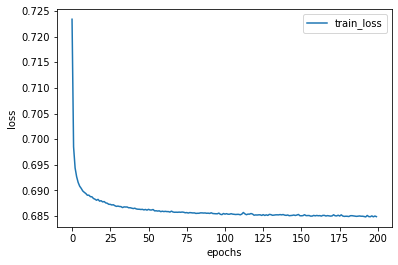

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import train_test_split
num_epochs = 200
learning_rate = 0.001
num_negatives = 1 # 4  1
global num_scale 
num_scale = 27862 # 69650 27862
batch_size = 256

model = NeuMF_getmodel()
model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics = ['accuracy'])
# load pima indians dataset
drug_latent_vector, disease_latent_vector, labels = get_train_instances(train_Martrix, num_negatives)

X_train1, X_test1, y_train1, y_test1 = train_test_split(drug_latent_vector, labels, test_size=0.2, random_state=24)
X_train2, X_test2, y_train2, y_test2 = train_test_split(disease_latent_vector, labels, test_size=0.2, random_state=24)
train_loss = []
# Training model
for epoch in range(num_epochs):
  
  # Generate training instances
  # Training
  # hist = model.fit([np.array(drug_latent_vector[:num_scale]), np.array(disease_latent_vector[:num_scale])], #input 
  #                  np.array(labels[:num_scale]), # labels 
  #                  batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
  hist = model.fit([np.array(X_train1), np.array(X_train2)],  
                   np.array(y_train1), 
                   batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
  train_loss.append(hist.history['loss'][0])
  print('Epoch: {:04d}'.format(epoch+1),
        'loss_train: {:.4f}'.format(hist.history['loss'][0]),
        'acc_train: {:.4f}'.format(hist.history['acc'][0]))
  
test_scores = model.evaluate([np.array(X_test1), np.array(X_test2)], y_test1)
print("Test set results:",
      "loss= {:.4f}".format(test_scores[0]),
      'acc_train: {:.4f}'.format(test_scores[1]))

import matplotlib.pyplot as plt
import time
epochs = len(train_loss)
plt.plot(range(0,epochs,1), train_loss, label='train_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
#plt.savefig("/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/image/"+time.strftime("%Y-%m-%d-%H_%M_%S",time.localtime(time.time()))+"Unet-过拟合C0.jpg")
plt.show()


In [ ]:
y_test1[:10]

[0, 0, 1, 1, 0, 1, 1, 0, 0, 1]

In [ ]:
y_test2[:10]

[0, 0, 1, 1, 0, 1, 1, 0, 0, 1]

In [ ]:
y_score1[:10]

array([[0.46111554],
       [0.2501036 ],
       [0.46137208],
       [0.376176  ],
       [0.46424112],
       [0.60141325],
       [0.5289528 ],
       [0.48491535],
       [0.5067387 ],
       [0.519097  ]], dtype=float32)

AUC :  0.7387751030914025


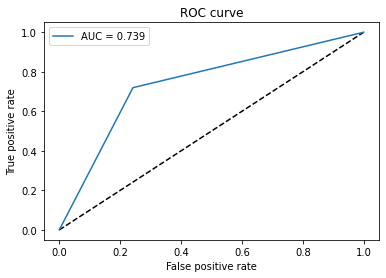

In [ ]:
# 计算AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import time

#y_score1 = model.predict([np.array(X_test1), np.array(X_test2)])

now = time.strftime("%Y-%m-%d-%H_%M_%S",time.localtime(time.time())) 
#Y_train0为真实标签，Y_pred_0为预测标签，注意，这里roc_curve为一维的输入，Y_train0是一维的
fpr, tpr, thresholds_keras = roc_curve(y_test1, y_score0)   
auc = auc(fpr, tpr)
print("AUC : ", auc)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/image/'+ now + 'ROC.jpg')
plt.show()

In [ ]:
# 归一化数据
from sklearn import preprocessing  
min_max_scaler = preprocessing.MinMaxScaler()  #标准化训练集数据 
data_train_nomal = min_max_scaler.fit_transform(y_score1)  #对测试集数据进行相同的归一化处理
data_train_nomal[:10]

In [ ]:
print('max:', data_train_nomal.max())
print('min:', data_train_nomal.min())

In [ ]:
def auc_calculate(labels,preds,n_bins=17420):
    postive_len = sum(labels)   #正样本数量（因为正样本都是1）
    negative_len = len(labels) - postive_len #负样本数量
    print('负样本数量:', negative_len)
    total_case = postive_len * negative_len #正负样本对
    pos_histogram = [0 for _ in range(n_bins)] 
    neg_histogram = [0 for _ in range(n_bins)]
    bin_width = 1.0 / n_bins
    for i in range(len(labels)):
        nth_bin = int(preds[i]/bin_width)
        if labels[i]==1:
            pos_histogram[nth_bin] += 1
        else:
            neg_histogram[nth_bin] += 1
    accumulated_neg = 0
    satisfied_pair = 0
    for i in range(n_bins):
        satisfied_pair += (pos_histogram[i]*accumulated_neg + pos_histogram[i]*neg_histogram[i]*0.5)
        accumulated_neg += neg_histogram[i]
    return satisfied_pair / float(total_case)
print("验证:",auc_calculate(labels[27862:], y_score1))

In [ ]:
from sklearn import metrics
'''使用real.csv和result.csv列数据，计算PR曲线的AUC值'''
precision, recall, _thresholds = metrics.precision_recall_curve(labels[69650:], data_train_nomal)
area = metrics.auc(recall, precision)
print(area) 